# 13장 - 텐서플로를 사용한 신경망 훈련(part 1)

In [1]:
from IPython.display import Image

# 텐서플로와 훈련 성능

## 성능 문제

이전 장들에서 보았던 사이킷런의 많은 함수는 여러 프로세스로 연산을 분산할 수 있다. 그러나 기본적으로 파이썬은 GIL(Global Interpreter Lock) 때문에 하나의 코어만 활용할 수 있다.  
멀티프로세싱 라이브러리를 사용하여 여러 개의 코어에 연산을 분산할 수 있지만 최신의 고성능 데스크톱 컴퓨터라도 여덟 개나 16개 이상의 코어를 가진 경우는 거의 없다.  

12장에서 구현했던 아주 간단한 다층 퍼셉트론을 생각해 보면 하나의 은닉층이 100개의 유닛을 가졌다.  
매우 단순한 이미지 분류 작업을 위해 모델을 훈련하는 데도 약 8만 개의 가중치 파라미터($[784\times100+100]+[100\times10+10]=79,510$)를 최적화해야 한다. MNIST는 비교적 작은 이미지(28X28 픽셀)이다. 은닉층을 추가하거나 고해상도 이미지를 다룰 경우에는 가중치 파라미터 개수가 급격히 늘어날 것이다. 이런 작업은 금방 단일 프로세스로는 수행하기 어려워진다. 그럼 어떻게 이런 문제를 효과적으로 해결할 수 있을까?  

이 문제에 대한 확실한 해결책은 일당백의 능력을 가진 GPU를 사용하는 것이다. 그래픽 카드를 컴퓨터 안에 포함된 작은 컴퓨터 클러스터로 생각할 수 있다.  

그렇다면 머신 러닝 작업에 GPU를 사용하기 어려운 이유가 있을까?  
특정 GPU에 맞는 코드를 작성하는 일은 파이썬 인터프리터에서 코드를 실행하는 것처럼 간단하지 않다. CUDA나 OpenCL처럼 특정 GPU를 사용할 수 있도록 도와주는 특별한 패키지가 있다. 하지만 CUDA나 OpenCL에서 코드를 작성하는 것은 머신러닝 알고리즘을 구현하고 실행하기에 편리한 환경이 아니다. 이런 이유 때문에 텐서플로가 개발되었다. 

## 텐서플로란?

텐서플로는 머신 러닝 알고리즘을 구현하고 실행하기 위한 프로그래밍 인터페이스로, 확장이 용이하고 다양한 플랫폼을 지원한다. 딥려닝을 위한 간편한 인터페이스도 포함하고 있다.  

머신 러닝 모델의 훈련 성능을 향상시키기 위해 텐서플로는 CPU와 GPU를 모두 활용할 수 있다. 하지만 GPU를 사용할 때만 최대 성능을 이끌어 낼 수 있다. 텐서플로는 공식적으로 CUDA 기반의 GPU를 지원한다.  
텐서플로는 프론트엔드 인터페이스로 여러 프로그래밍 언어를 지원한다.  
파이썬 사용자라면 운이 좋다. 텐서플로의 파이썬 API는 완전히 성숙되어 있기 때문에 많은 머신 러닝, 딥러닝 기술자에게 인기가 높다.  

텐서플로는 일련의 노드(node)로 구성된 계산 그래프를 만든다. 각 노드는 0개 이상의 입력이나 출력을 가질 수 있는 연산을 표현한다. 이런 연산의 입력과 출력을 참조하기 위한 심벌릭 핸들(symbolic handle)로 텐서(tensor)가 만들어진다.  

수학적으로 텐서를 스칼라(scaler), 벡터, 행렬 등의 일반화 형태로 이해할 수 있다. 좀 더 구체적으로 말하면 스칼라는 랭크(rank) 0 텐서로 정의할 수 있고 벡터는 랭크 1 텐서, 행렬은 랭크 2 텐서로 정의할 수 있다.  
세 번째 차원으로 쌓은 행렬은 랭크 3 텐서로 정의할 수 있다. 하지만 텐서플로에서 실제 값은 넘파이 배열로 저장되고 텐서는 이 배열에 대한 참조를 제공한다.  

In [2]:
Image(url='https://git.io/JL5io', width=500)

# 텐서플로 처음 시작하기

## 텐서플로 설치

사용하는 시스템에 따라 다르지만 일반적으로 파이썬의 pip 인스톨러를 사용하여 PyPI로부터 텐서플로를 설치할 수 있다.  
다음 명령을 터미널에서 실행한다.  
`> pip install tensorflow`  

GPU를 사용하는 경우라면 NVIDIA 호환 그래픽 카드가 필요하고 CUDA 툴킷과 NVIDIA cuDNN 라이브러리를 설치해야 한다.  
이런 조건이 만족되면 다음과 같이 텐서플로 GPU 버전을 설치할 수 있다.  
`> pip install tensorflow-gpu`  
</br>
</br>

>M1 환경에 tensorflow 설치  

M1 환경에 tensorflow를 설치하기 위해서는 Miniforge를 설치해야 한다.  
(Miniforge는 Apple Silicon의 arm64를 공식적으로 지원하는 conda이다. [다운로드 링크](https://github.com/conda-forge/miniforge/))  

1. conda 가상환경 구축 & 실행  
`> conda create -n 가상환경 이름 python=3.8`  
`> conda activate 가상환경 이름`  

2. M1 tensorflow 설치  
`> conda install -c apple tensorflow-deps`  
`> python -m pip install tensorflow-macos`  
`> python -m pip install tensorflow-metal`  

## 텐서플로에서 텐서 만들기

In [3]:
import tensorflow as tf
print('텐서플로 버전:', tf.__version__)
import numpy as np

np.set_printoptions(precision=3)

Init Plugin
텐서플로 버전: 2.5.0
Init Graph Optimizer
Init Kernel


In [4]:
a = np.array([1, 2, 3], dtype=np.int32)
b = [4, 5, 6]

t_a = tf.convert_to_tensor(a)
t_b = tf.convert_to_tensor(b)

Metal device set to: 

2022-11-22 16:04:25.533666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-22 16:04:25.533789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [5]:
print(t_a)
print(t_b)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([4 5 6], shape=(3,), dtype=int32)


In [6]:
tf.is_tensor(a), tf.is_tensor(t_a)

(False, True)

텐서 `t_a`, `t_b`는 `shape=(3,)` 속성과 원본 데이터에서 유도된 `dtype=int32` 속성과 함께 출력된다.  
넘파이 배열과 비슷하게 이 속성을 확인할 수 있다. 

In [7]:
t_ones = tf.ones((2, 3))

t_ones.shape

TensorShape([2, 3])

텐서가 참조하는 값을 얻어려면 간단히 텐서의 `.numpy()` 메서드를 호출하면 된다.

In [8]:
t_ones.numpy()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

마지막으로 상수 값을 가진 텐서를 다음과 같이 만들 수도 있다.

In [9]:
const_tensor = tf.constant([1.2, 5, np.pi], dtype=tf.float32)

print(const_tensor)

tf.Tensor([1.2   5.    3.142], shape=(3,), dtype=float32)


### Note
`tf.conver_to_tensor()` 는 `tf.constant()` 함수와 다르게 `tf.Variable` 객체도 입력받을 수 있다. 이외에도 `tf.fill()` 함수와 `tf.one_hot()` 함수를 사용하여 텐서를 만들 수 있다.  

`tf.fill()` 함수는 원하는 스칼라 값으로 채워진 텐서를 만든다. 첫 번째 매개변수에는 `tf.ones()` 함수처럼 텐서의 크기를 전달한다. 두 번째 매개변수에 채우고자 하는 스칼라 값을 전달한다. 

In [10]:
tf.fill((2, 3), 1)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

큰 사이즈의 텐서를 만들 때 `tf.fill` 함수가 `tf.ones` 함수보다 효율적이다.  

`tf.one_hot()` 함수는 원-핫 인코딩 행렬을 만들어 주는 편리한 함수이다. 첫 번째 매개변수에 원-핫 인코딩 위치를 나타내는 인덱스를 전달하고 두 번째 매개변수에는 원-핫 인코딩 벡터의 길이를 전달한다. 

In [11]:
tf.one_hot([0, 1, 2], 4)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

## 텐서의 데이터 타입과 크기 조작

모델이나 연산에 맞는 입력을 준비하려면 텐서를 조작하는 방법을 배워야 한다.  
텐서플로의 `cast`, `reshape`, `transpose`, `squeeze` 함수를 사용한다.  

`tf.cast()` 함수는 텐서의 데이터 타입을 원하는 타입으로 바꿀 수 있다.

In [12]:
t_a_new = tf.cast(t_a, tf.int64)

print(t_a_new.dtype)

<dtype: 'int64'>


어떤 연산은 특정 차원(즉, 랭크)의 입력 텐서를 필요로 한다. 차원은 원소의 크기와 관련이 있다. 따라서 텐서의 크기를 바꾸고 차원을 추가하거나 불필요한 차원을 제거할 수 있어야 한다.  
텐서플로는 이를 위해 `tf.transpose()`, `tf.reshape()`, `tf.squeeze()` 와 같은 함수를 제공한다.  

In [13]:
# 텐서 전치하기
t = tf.random.uniform(shape=(3, 5))

t_tr = tf.transpose(t)
print(t.shape, ' --> ', t_tr.shape)

(3, 5)  -->  (5, 3)


In [14]:
# 텐서 크기 바꾸기(예를 들어 1D 벡터에서 2D 배열로)
t = tf.zeros((30,))

t_reshape = tf.reshape(t, shape=(5, 6))

print(t_reshape.shape)

(5, 6)


In [15]:
# 불필요한 차원 삭제하기(크기가 1인 차원은 불필요하다)
t = tf.zeros((1, 2, 1, 4, 1))

t_sqz = tf.squeeze(t, axis=(2, 4))

print(t.shape, ' --> ', t_sqz.shape)

(1, 2, 1, 4, 1)  -->  (1, 2, 4)


## 텐서에 수학 연산 적용

먼저 두 개의 랜덤한 텐서를 만들어 보자.  
하나는 [-1,1) 사이의 규등 분포로 만들고 다른 하나는 표준 정규 분포를 사용해서 만든다.

In [16]:
tf.random.set_seed(1)

t1 = tf.random.uniform(shape=(5, 2), 
                       minval=-1.0,
                       maxval=1.0)

t2 = tf.random.normal(shape=(5, 2), 
                      mean=0.0,
                      stddev=1.0)

In [17]:
t1

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-0.546, -0.066],
       [-0.639,  0.088],
       [-0.682,  0.425],
       [-0.405, -0.969],
       [-0.164, -0.659]], dtype=float32)>

In [18]:
t2

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.403, -1.088],
       [-0.063,  1.337],
       [ 0.712, -0.489],
       [-0.764, -1.037],
       [-1.252,  0.021]], dtype=float32)>

t1과 t2는 크기가 같다.  
다음과 같이 t1과 t2를 원소별 곱셈할 수 있다.

In [19]:
t3 = tf.multiply(t1, t2).numpy()
print(t3)

[[-0.22   0.072]
 [ 0.04   0.117]
 [-0.486 -0.208]
 [ 0.31   1.005]
 [ 0.206 -0.014]]


특정 축(들)을 따라 평균, 합. 표준 편차를 계산하려면 `tf.math.reduce_mean()`, `tf.math_reduce_sum()`, `tf.math.reduce_std()`를 사용할 수 있다.

In [20]:
# t1의 각 열 평균은 다음과 같이 계산
t4 = tf.math.reduce_mean(t1, axis=0)

print(t4)

tf.Tensor([-0.487 -0.236], shape=(2,), dtype=float32)


t1과 t2의 행렬 곱셈(즉, $t_{1}\times t^{T}_{2}$)은 `tf.linalg.matmul()` 함수를 사용하여 계산할 수 있다.

In [21]:
t5 = tf.linalg.matmul(t1, t2, transpose_b=True)

print(t5.numpy())

[[-0.148 -0.054 -0.356  0.486  0.682]
 [-0.353  0.158 -0.498  0.397  0.802]
 [-0.737  0.611 -0.693  0.081  0.863]
 [ 0.891 -1.27   0.186  1.315  0.487]
 [ 0.651 -0.871  0.206  0.809  0.192]]


한편 t1을 전치하여 $t^{T}_{1}\times t_{2}$를 계산하면 2X2 크기 배열을 얻는다.

In [22]:
t6 = tf.linalg.matmul(t1, t2, transpose_a=True)

print(t6.numpy())

[[-0.15   0.49 ]
 [ 1.836  0.973]]


마지막으로 `tf.norm()` 함수를 사용하여 텐서의 $L^{P}$ 노름을 계산한다.

In [23]:
norm_t1 = tf.norm(t1, ord=2, axis=1).numpy()

print(norm_t1)

[0.55  0.645 0.804 1.051 0.679]


In [24]:
# 넘파이 함수를 사용해서 비교
np.sqrt(np.sum(np.square(t1), axis=1))

array([0.55 , 0.645, 0.804, 1.051, 0.679], dtype=float32)

## split(), stack(), concat() 함수

이 절에서 하나의 텐서를 여러 개의 텐서로 나누는 텐서플로 연산을 알아본다. 또는 반대로 여러 개의 텐서를 쌓거나 연결하여 하나의 텐서로 만드는 연산도 알아본다.  

하나의 텐서를 두 개 이상의 텐서로 나누어야 한다고 가정해보자. 이를 위해 텐서플로는 편리하게 `tf.split()` 함수를 제공한다. 이 함수는 입력된 텐서를 동일한 크기의 텐서 리스트로 나눈다.  
`num_or_size_splits` 매개변수에 분할한 텐서 개수를 지정하고 axis 매개변수로 원하는 차원을 지정할 수 있다. 또는 리스트로 원하는 크기를 전달할 수도 있다. 

In [25]:
# 분할 개수 지정하기
tf.random.set_seed(1)

t = tf.random.uniform((6,))

print(t.numpy())

t_splits = tf.split(t, 3)

[item.numpy() for item in t_splits]

[0.227 0.467 0.18  0.544 0.159 0.712]


[array([0.227, 0.467], dtype=float32),
 array([0.18 , 0.544], dtype=float32),
 array([0.159, 0.712], dtype=float32)]

In [26]:
# 다른 분할 크기 전달하기
tf.random.set_seed(1)
t = tf.random.uniform((5,))

print(t.numpy())

t_splits = tf.split(t, num_or_size_splits=[3, 2]) # 크기 5인 텐서를 크기 3과 2인 텐서 두개로 나눔.

[item.numpy() for item in t_splits]

[0.227 0.467 0.18  0.544 0.159]


[array([0.227, 0.467, 0.18 ], dtype=float32),
 array([0.544, 0.159], dtype=float32)]

이따금 여러 개의 텐서를 연결하거나 쌓아서 하나의 텐서를 만들어야 하는 경우가 있다. 이런 경우 tf.stack() 과 tf.concat() 같은 텐서플로 함수를 사용하면 편리하다.  

예를 들어 크기가 3이고 1로 채워진 1D 텐서 A와 2이고 0으로 채워진 1D 텐서 B가 있다고 가정해보자. 이 두 텐서를 연결하여 크기가 5인 1D 텐서 C를 만들 수 있다. 

In [27]:
A = tf.ones((3,))
B = tf.zeros((2,))
print("A: ",A.numpy())
print("B: ",B.numpy())

C = tf.concat([A, B], axis=0)
print("C: ",C.numpy())

A:  [1. 1. 1.]
B:  [0. 0.]
C:  [1. 1. 1. 0. 0.]


텐서 A와 B의 크기가 모두 3이라면 두 텐서를 쌓아서 2D 텐서 S를 만들 수 있다.

In [28]:
A = tf.ones((3,))
B = tf.zeros((3,))
print("A: ",A.numpy())
print("B: ",B.numpy())

S = tf.stack([A, B], axis=1)
print("S: \n",S.numpy())

A:  [1. 1. 1.]
B:  [0. 0. 0.]
S: 
 [[1. 0.]
 [1. 0.]
 [1. 0.]]


# 텐서플로 데이터셋 API(tf.data)를 사용하여 입력 파이프라인 구축

심층 신경망 모델을 훈련할 때 일반적으로 이전 장에서 본 확률적 경사 하강법과 같은 반복적인 최적화 알고리즘을 사용하여 모델을 점진적으로 훈련한다.  

커라스 API는 신경망 모델을 만들기 위한 텐서플로의 래퍼(wrapper)이다. 케라스 API는 모델 훈련을 위해 `.fit()` 메서드를 제공한다.  
훈련 데이터셋이 작고 텐서로 메모리에 적재할 수 있는 경우에는 이 텐서를 사용하여 텐서플로 모델을 `.fit()` 메서드로 바로 훈련할 수 있다. 하지만 데이터셋이 컴퓨터 메모리보다 클 경우 저장 장치에서 데이터를 나누어 **배치 단위로 적재**해야 한다.(이 장에서는 텐서플로에서 사용하는 용어와 맞추기 위해 미니 배치 대신 배치라고 쓴다.) 또한, 데이터를 변환하거나 전처리 단계를 수행하기 위한 데이터 처리 파이프라인이 필요할 수 있다. 예를 들어 평균을 0에 맞추고 스케일을 조정하거나 과대적합을 막고 훈련 과정을 증식하기 위해 노이즈를 삽입할 수 있다.  

매번 전처리 함수를 수동으로 적용한느 것은 매우 번거로운 일이다. 다행히 텐서플로는 효율적이고 간편한 전처리 파이프라인을 만들어 주는 특별한 클래스를 제공한다. 

## 텐서에서 텐서플로 데이터셋 만들기

데이터가 텐서, 파이썬 리스트, 넘파이 배열과 같은 형태로 준비되어 있다면 `tf.data.Dataset.from_tensor_slices()` 함수를 사용하여 손쉽게 데이터셋을 만들 수 있다.  
이 함수는 Dataset 클래스의 객체를 반환한다. 이 객체를 사용하여 입력 데이터셋에 있는 개별 원소를 순환시킬 수 있다. 

In [29]:
a = [1.2, 3.4, 7.5, 4.1, 5.0, 1.0]

ds = tf.data.Dataset.from_tensor_slices(a)

print(ds)

<TensorSliceDataset shapes: (), types: tf.float32>


다음과 같이 데이터셋의 개별 원소를 순환할 수 있다.

In [30]:
for item in ds:
    print(item)

tf.Tensor(1.2, shape=(), dtype=float32)
tf.Tensor(3.4, shape=(), dtype=float32)
tf.Tensor(7.5, shape=(), dtype=float32)
tf.Tensor(4.1, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


이 데이터셋에서 배치 크기 3의 배치를 만들려면 다음과 같이 `batch()` 메서드를 사용한다.

In [31]:
ds_batch = ds.batch(3)

for i, elem in enumerate(ds_batch, 100):
    print('batch {}:'.format(i), elem.numpy())

batch 100: [1.2 3.4 7.5]
batch 101: [4.1 5.  1. ]


앞의 코드는 이 데이터셋에서 두 개의 배치를 만든다. 처음 세 개의 원소가 배치 #1에 들어가고 남은 원소가 배치 #2에 들어간다.  
`batch()` 메서드에는 텐서의 원소 개수가 배치 크기로 나누어 떨어지지 않을 때 사용할 수 있는 `drop_remainder` 매개변수가 있다. `drop_remainder` 매개변수의 기본값은 `False`이다. 

## 두 개의 텐서를 하나의 데이터셋으로 연결

종종 데이터는 두 개(또는 그 이상)의 텐서로 구성된다. 예를 들어 특성을 위한 텐서와 레이블을 위한 텐서가 있다. 이런 경우 이 텐서를 연결하여 하나의 데이터셋으로 만들면 두 텐서의 원소를 튜플로 추출할 수 있다.  

`t_x` 와 `t_y` 두 개의 텐서가 있다고 가정해보자. `t_x`의 각 샘플은 세 개의 특성을 가지고 있으며, `t_y`는 샘플의 클래스 레이블을 가지고 있다. 

In [32]:
tf.random.set_seed(1)

t_x = tf.random.uniform([4, 3], dtype=tf.float32)
t_y = tf.range(4)

print("텐서 t_x: \n", t_x, '\n')

print("텐서 t_y: \n", t_y)

텐서 t_x: 
 tf.Tensor(
[[0.227 0.467 0.18 ]
 [0.544 0.159 0.712]
 [0.297 0.015 0.418]
 [0.17  0.567 0.805]], shape=(4, 3), dtype=float32) 

텐서 t_y: 
 tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)


이 두 텐서를 연결하여 데이터셋을 만들어 보자.  
두 텐서의 원소는 1:1 대응이 되어야 한다. 

In [33]:
## 방법 1:
ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)
    
ds_joint = tf.data.Dataset.zip((ds_x, ds_y))

for example in ds_joint:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.227 0.467 0.18 ]   y:  0
  x:  [0.544 0.159 0.712]   y:  1
  x:  [0.297 0.015 0.418]   y:  2
  x:  [0.17  0.567 0.805]   y:  3


먼저 두 개의 데이터셋 `ds_x`와 `ds_y`를 만든다.  
그다음 zip 함수를 사용하여 두 데이터셋을 연결한 데이터셋을 만든다. 또는 `tf.data.Dataset.from_tensor_slices()` 함수로 텐서를 바로 연결하여 데이터셋을 만들 수 있다. 

In [34]:
## 방법 2:
ds_joint = tf.data.Dataset.from_tensor_slices((t_x, t_y))

for example in ds_joint:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.227 0.467 0.18 ]   y:  0
  x:  [0.544 0.159 0.712]   y:  1
  x:  [0.297 0.015 0.418]   y:  2
  x:  [0.17  0.567 0.805]   y:  3


그다음 데이터셋의 각 원소에 변환을 적용하는 방법을 알아보자.  
앞서 만든 `ds_joint` 데이터셋을 사용해서 특성 값의 범위를 [-1,1)로 조정한다. 현재 `t_x` 값은 균등 분포를 기반으로 [0,1) 범위를 가지고 있다. 

In [35]:
ds_trans = ds_joint.map(lambda x, y: (x*2-1.0, y))

for example in ds_trans:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [-0.546 -0.066 -0.639]   y:  0
  x:  [ 0.088 -0.682  0.425]   y:  1
  x:  [-0.405 -0.969 -0.164]   y:  2
  x:  [-0.659  0.134  0.61 ]   y:  3


2022-11-22 16:04:27.008023: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-22 16:04:27.008189: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


이런 종류의 변환은 사용자 정의 함수를 위해 사용할 수 있다. 예를 들어 디스크에 있는 이미지 파일 이름 목록에서 만든 데이터셋을 가지고 있다면 이 파일 이름으로 이미지를 로드하는 함수를 정의하고 `.map()` 메서드를 호출하여 이 함수를 적용할 수 있다. 

## shuffle(), batch(), repeat() 메서드

2장에서 언급했듯이 확률적 경사 하강법 최적화 방식으로 신경망 모델을 훈련하려면 훈련 데이터를 무작위로 섞은 배치로 만들어 주입하는 것이 중요하다.  
이제 배치를 만드는 것 외에도 데이터셋을 섞거나 재순환하는 방법을 알아보자.  

먼저 ds_joint 데이터셋을 섞은 데이터셋을 만들어 보자. 

In [36]:
tf.random.set_seed(1)
ds = ds_joint.shuffle(buffer_size=len(t_x))

for example in ds:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.297 0.015 0.418]   y:  2
  x:  [0.544 0.159 0.712]   y:  1
  x:  [0.227 0.467 0.18 ]   y:  0
  x:  [0.17  0.567 0.805]   y:  3


x와 y 원소 간의 일대일 대응을 깨뜨리지 않고 행을 섞었다. `.shuffle()` 메서드는 섞기 전에 데이터셋에서 얼마나 많은 원소를 꺼낼 것인지 결정하는 `butter_size` 매개변수가 필요하다.  
버퍼에 있는 원소는 랜덤하게 추출되고 빈자리는 (섞여 있지 않은) 원본 데이터셋의 다음 원소로 채워진다. 따라서 `buffer_size`를 작게 설정하면 데이터셋을 완전히 섞지 않을 수 있다.  

데이터셋이 작을 때 비교적 작은 `buffer_size`를 선택하면 데이터셋이 완전히   랜덤하게 섞이지 않기 때문에 신경망의 예측 성능에 부정적인 영향을 끼칠 수 있다. 하지만 실제로 딥러닝에서 종종 다루는 비교적 대량의 데이터셋으로 작업할 때 크게 영향을 미치지 않는다. 에포크마다 완전히 랜덤하게 섞이게 하려면 앞의 코드처럼 훈련 샘플의 개수와 동일한 버퍼 크기를 지정할 수 있다.  

`.batch()` 메서드를 사용하여 모델 훈련을 위해 데이터셋을 배치로 나누었다. ds_joint 데이터셋에서 이런 배치를 만들고 어떻게 구성되어 있는지 확인해 보자. 

In [37]:
ds = ds_joint.batch(batch_size=3,
                    drop_remainder=False)

batch_x, batch_y = next(iter(ds))

print('배치 x: \n', batch_x.numpy())

print('배치 y:   ', batch_y.numpy())

배치 x: 
 [[0.227 0.467 0.18 ]
 [0.544 0.159 0.712]
 [0.297 0.015 0.418]]
배치 y:    [0 1 2]


또한, 여러 에포크 동안 모델을 훈련할 때 필요한 에포크 횟수 만큼 데이터셋을 섞어 추출해야 한다. 배치 데이터셋을 두 번 반복해보자.

In [38]:
ds = ds_joint.batch(3).repeat(count=2)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (3, 3) [0 1 2]
1 (1, 3) [3]
2 (3, 3) [0 1 2]
3 (1, 3) [3]


각 배치가 두 번 출력된다. 배치와 반복 연산의 순서를 바꾸면 결과가 달라진다. 

In [39]:
ds = ds_joint.repeat(count=2).batch(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (3, 3) [0 1 2]
1 (3, 3) [3 0 1]
2 (2, 3) [2 3]


두 결과의 차이를 눈여겨보자. 먼저 배치를 만들고 반복할 경우 네 개의 배치가 만들어졌다.  
반면 먼저 반복햇을 때는 세 개의 배치가 만들어졌다.  

마지막으로 이 세 개의 연산(batch(), shuffle(), repeat())의 동작 방식을 잘 이해하기 위해 다른 순서로 실험해 보자.   

먼저 `(1) shuffle(), (2) batch(), (3) repeat()` 순서대로 연산을 실행해보자.

In [40]:
tf.random.set_seed(1)

## 순서 1: shuffle -> batch -> repeat
ds = ds_joint.shuffle(4).batch(2).repeat(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [2 1]
1 (2, 3) [0 3]
2 (2, 3) [0 3]
3 (2, 3) [1 2]
4 (2, 3) [3 0]
5 (2, 3) [1 2]


이제 순서를 `(2) batch(), (1) shuffle(), (3) repeat()`로 바꾸어 보자.

In [41]:

tf.random.set_seed(1)

## 순서 2: batch -> shuffle -> repeat
ds = ds_joint.batch(2).shuffle(4).repeat(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [2 3]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]


첫 번째 코드 예제(`(1) shuffle(), (2) batch(), (3) repeat()`)에서 기대대로 섞인 데이터셋을 얻었다. 하지만 두 번째 경우(`(2) batch(), (1) shuffle(), (3) repeat()`)일 때 한 배치 안에 원소는 전혀 섞이지 않았다.  
타깃 변수 y에 담긴 텐서를 자세히 들여다보면 섞이지 않았다는 것을 알 수 있다. 모든 배치는 `[y=0, y=1]` 또는 `[y=2, y=3]` 쌍을 담고 있다. `[y=2, y=0]`, `[y=1. y=3]`과 같이 섞인 경우를 볼 수 없다. 이 결과가 우연이 아닌 것을 확인하려면 반복 횟수를 3보다 늘려보아라.  



In [42]:
tf.random.set_seed(1)

## 순서 2: batch -> shuffle -> repeat
ds = ds_joint.batch(2).shuffle(4).repeat(20)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [2 3]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]
6 (2, 3) [2 3]
7 (2, 3) [0 1]
8 (2, 3) [2 3]
9 (2, 3) [0 1]
10 (2, 3) [2 3]
11 (2, 3) [0 1]
12 (2, 3) [2 3]
13 (2, 3) [0 1]
14 (2, 3) [2 3]
15 (2, 3) [0 1]
16 (2, 3) [0 1]
17 (2, 3) [2 3]
18 (2, 3) [2 3]
19 (2, 3) [0 1]
20 (2, 3) [0 1]
21 (2, 3) [2 3]
22 (2, 3) [2 3]
23 (2, 3) [0 1]
24 (2, 3) [2 3]
25 (2, 3) [0 1]
26 (2, 3) [2 3]
27 (2, 3) [0 1]
28 (2, 3) [0 1]
29 (2, 3) [2 3]
30 (2, 3) [0 1]
31 (2, 3) [2 3]
32 (2, 3) [2 3]
33 (2, 3) [0 1]
34 (2, 3) [2 3]
35 (2, 3) [0 1]
36 (2, 3) [2 3]
37 (2, 3) [0 1]
38 (2, 3) [0 1]
39 (2, 3) [2 3]


In [43]:
tf.random.set_seed(1)

## 순서 3: batch -> repeat -> shuffle
ds = ds_joint.batch(2).repeat(3).shuffle(4)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [0 1]
2 (2, 3) [2 3]
3 (2, 3) [2 3]
4 (2, 3) [0 1]
5 (2, 3) [2 3]


## 로컬 디스크에 있는 파일에서 데이터셋 만들기

In [44]:
!mkdir cat_dog_images
!wget https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch13/cat_dog_images/cat-01.jpg
!wget https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch13/cat_dog_images/cat-02.jpg
!wget https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch13/cat_dog_images/cat-03.jpg
!wget https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch13/cat_dog_images/dog-01.jpg
!wget https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch13/cat_dog_images/dog-02.jpg
!wget https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch13/cat_dog_images/dog-03.jpg
!mv *.jpg cat_dog_images/

mkdir: cat_dog_images: File exists
--2022-11-22 16:04:27--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch13/cat_dog_images/cat-01.jpg
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 139707 (136K) [image/jpeg]
저장 위치: `cat-01.jpg'

cat-01.jpg          100%[===================>] 136.43K  --.-KB/s    /  0.01s   

2022-11-22 16:04:28 (13.5 MB/s) - `cat-01.jpg' 저장함 [139707/139707]

--2022-11-22 16:04:28--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch13/cat_dog_images/cat-02.jpg
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... 연결했습니다.
HT

In [45]:
import pathlib

imgdir_path = pathlib.Path('/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images')

file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])

print(file_list)

['/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/cat-01.jpg', '/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/cat-02.jpg', '/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/cat-03.jpg', '/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/dog-01.jpg', '/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/dog-02.jpg', '/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/dog-03.jpg']


이미지 크기:  (900, 1200, 3)
이미지 크기:  (900, 1200, 3)
이미지 크기:  (900, 742, 3)
이미지 크기:  (800, 1200, 3)
이미지 크기:  (800, 1200, 3)
이미지 크기:  (900, 1200, 3)


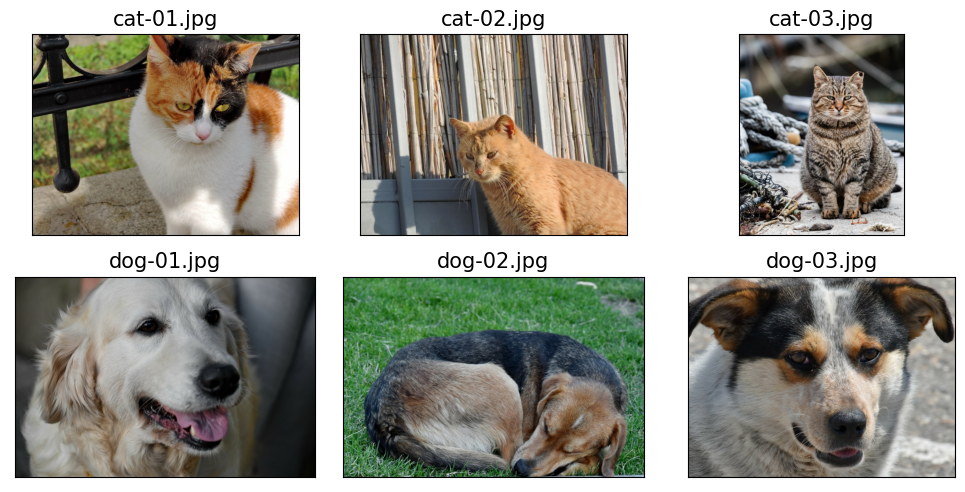

In [46]:
import matplotlib.pyplot as plt
import os


fig = plt.figure(figsize=(10, 5))
for i,file in enumerate(file_list):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print('이미지 크기: ', img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
    
# plt.savefig('images/13_1.png', dpi=300)
plt.tight_layout()
plt.show()

출력된 이미지와 크기를 보면 다른 비율의 이미지라는 것을 알 수 있다.  
이미지의 가로세로 비율(또는 데이터 배열 크기)을 보면 일부 이미지는 900픽셀의 높이와 1200픽셀의 너비이다. 다른 이미지는 800 X 1200이고, 하나는 900 X 742이다. 나중에 이미지를 전처리하여 동일한 크기로 만든다. 레이블은 파일 이름 안에 포함되어 있다. 따라서 파일 이름 리스트에서 레이블을 추출하여 강아지는 1, 고양이는 0으로 할당한다.

In [47]:
labels = [1 if 'dog' in os.path.basename(file) else 0
          for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


이제 파일 이름의 리스트와 레이블의 리스트 두 개가 준비되었다. 이전 절에서 두 개의 텐서를 연결하여 데이터셋을 만드는 두 가지 방법을 배웠다.  
여기서는 두 번째 방법을 사용한다. 

In [48]:
ds_files_labels = tf.data.Dataset.from_tensor_slices(
    (file_list, labels))

for item in ds_files_labels:
    print(item[0].numpy(), item[1].numpy())

b'/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/cat-01.jpg' 0
b'/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/cat-02.jpg' 0
b'/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/cat-03.jpg' 0
b'/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/dog-01.jpg' 1
b'/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/dog-02.jpg' 1
b'/Users/hanhyeongu/Desktop/HG/code study/ML_DL_study/ch13/cat_dog_images/dog-03.jpg' 1


파일 이름과 레이블을 포함하고 있으므로 `ds_files_labels`란 이름의 데이터셋을 만들었다.  
그다음 이 데이터셋에 변환을 적용하여 파일 경로에서 이미지를 로드하고 원본 데이터를 디코딩 한 후 원하는 크기로 변경해야 한다.  
앞서 `.map()` 메서드를 사용해서 람다 함수를 적용하는 방법을 보았다. 하지만 이번에는 여러 전처리 단계를 적용해야 하기 떄문에 `.map()` 메서드를 호출할 때 사용할 헬퍼 함수를 만들자.

(80, 120, 3) 0
(80, 120, 3) 0
(80, 120, 3) 0
(80, 120, 3) 1
(80, 120, 3) 1
(80, 120, 3) 1


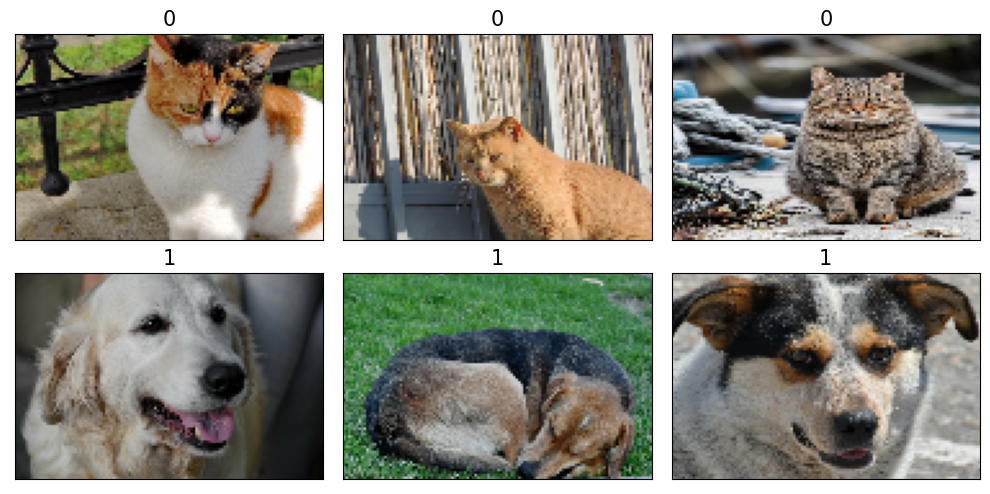

In [49]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image /= 255.0

    return image, label

img_width, img_height = 120, 80

ds_images_labels = ds_files_labels.map(load_and_preprocess)

fig = plt.figure(figsize=(10, 5))
for i,example in enumerate(ds_images_labels):
    print(example[0].shape, example[1].numpy())
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title('{}'.format(example[1].numpy()), 
                 size=15)
    
plt.tight_layout()
# plt.savefig('images/13_2.png', dpi=300)
plt.show()

`load_and_preprocess()` 함수는 네 개의 단계를 하나의 함수에 넣었다. 원본 이미지를 로드하고 디코딩한 후 이미지 크기를 변경한다. 그다음 이 함수는 이전 절에서 배웠던 연산을 적용하고 순환시킬 수 있는 데이터셋을 반환한다.

## tensorflow_datasets 라이브러리에서 데이터셋 로드

`tensorflow_datasets` 라이브러리는 딥러닝 모델을 훈련하고 평가하는 데 무료로 사용할 수 있는 훌륭한 데이터셋을 제공한다.  
이 데이터셋은 잘 정리되어 있고 풍부한 설명을 제공한다. 특성과 레이블의 형태와 타입, 차원이 담겨 있고 데이터셋을 소개한 원본 논문을 BibTeX 포맷으로 인용하고 있다. 또 다른 장점은 이 데이터셋들은 모두 `tf.data.Dataset` 객체로 사용할 준비가 되어 있다는 것이다. 따라서 이전 절에서 다룬 모둔 함수를 바로 사용할 수 있다.  

In [50]:
!pip install --upgrade tensorflow-datasets

In [51]:
import tensorflow_datasets as tfds

print(len(tfds.list_builders()))
print(tfds.list_builders()[:5])

/Users/hanhyeongu/miniforge3/envs/hg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-22 16:04:35.677339: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


1122
['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset']


앞의 코드를 실행하면 현재 1122개의 데이터셋이 가능하다는 것을 보여 준다.(이 장을 쓰는 시점에 1122개이지만 이 숫자는 계속 증가할 것이다.)   
처음 다섯 개의 데이터셋을 출력해 보았다.  

데이터셋을 내려받는 방법은 두 가지이다.  
첫 번쨰 방법은 세 단계로 구성된다.  
1. 데이터셋의 `builder()` 함수를 호출한다.
2. `download_and_prepare()` 메서드를 실행한다.
3. `as_dataset()` 메서드를 호출한다.  

CelebA 데이터셋 다운로드하기

In [52]:
celeba_bldr = tfds.builder('celeb_a')

print(celeba_bldr.info.features)
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features.keys())
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features['image'])
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features['attributes'].keys())
print('\n', 30*"=", '\n')
print(celeba_bldr.info.citation)

FeaturesDict({
    'attributes': FeaturesDict({
        '5_o_Clock_Shadow': tf.bool,
        'Arched_Eyebrows': tf.bool,
        'Attractive': tf.bool,
        'Bags_Under_Eyes': tf.bool,
        'Bald': tf.bool,
        'Bangs': tf.bool,
        'Big_Lips': tf.bool,
        'Big_Nose': tf.bool,
        'Black_Hair': tf.bool,
        'Blond_Hair': tf.bool,
        'Blurry': tf.bool,
        'Brown_Hair': tf.bool,
        'Bushy_Eyebrows': tf.bool,
        'Chubby': tf.bool,
        'Double_Chin': tf.bool,
        'Eyeglasses': tf.bool,
        'Goatee': tf.bool,
        'Gray_Hair': tf.bool,
        'Heavy_Makeup': tf.bool,
        'High_Cheekbones': tf.bool,
        'Male': tf.bool,
        'Mouth_Slightly_Open': tf.bool,
        'Mustache': tf.bool,
        'Narrow_Eyes': tf.bool,
        'No_Beard': tf.bool,
        'Oval_Face': tf.bool,
        'Pale_Skin': tf.bool,
        'Pointy_Nose': tf.bool,
        'Receding_Hairline': tf.bool,
        'Rosy_Cheeks': tf.bool,
        'Sidebu

이는 데이터셋 구조를 이해할 수 있는 유용한 정보를 제공한다. 특성은 'image', 'lnadmarks', 'attributes' 세 개의 키를 가진 딕셔너리로 저장되어 있다.  

'image'키는 유명 인사의 얼굴 이미지를 담고 있다. 'landmarks' 키는 얼굴에서 추출한 위치로 구성된 딕셔너리를 담고 있다. 예를 들어 눈의 위치, 코의 위치 등이다. 'attributes' 에는 이미지에 있는 사람의 얼굴 속성 40개를 담은 딕셔너리가 들어 있다. 예를 들어 얼굴 표정, 화장 머리카락 등이다.  

그다음 `download_and_prepare()` 메서드를 호출한다. 이 메서드는 데이터를 내려받고 모든 텐서플로 데이터셋을 위해 지정된 폴더에 저장한다. 이미 한 번 이 작업을 수행하여 데이털르 내려받았다면 지정된 폴더를 확인해서 다시 내려받지 않는다. 

In [53]:
# 데이터 다운로드하고 디스크에 저장합니다
celeba_bldr.download_and_prepare()

그다음 데이터셋 객체를 만든다.

In [54]:
# 디스크에서 tf.data.Datasets으로 데이터 로드합니다
datasets = celeba_bldr.as_dataset(shuffle_files=False)

datasets.keys()

dict_keys(['train', 'validation', 'test'])

이 데이터셋은 이미 훈련, 테스트, 검증 데이터셋으로 나뉘어져 있다. 이미지 샘플이 어떻게 구성되어 있는지 확인하려면 다음 코드를 실행하면 된다.

In [55]:
#import tensorflow as tf
ds_train = datasets['train']
assert isinstance(ds_train, tf.data.Dataset)

example = next(iter(ds_train))
print(type(example))
print(example.keys())

<class 'dict'>
dict_keys(['attributes', 'image', 'landmarks'])


이 데이터셋의 원소는 딕셔너리로 구성된다. 이 데이터셋을 훈련할 때 지도 학습의 딥러닝 모델에 전달하려면 (특성, 레이블) 튜플로 재구성해야 한다. 

In [56]:
ds_train = ds_train.map(lambda item: 
     (item['image'], tf.cast(item['attributes']['Male'], tf.int32)))

마지막으로 이 데이터셋에서 18개의 샘플로 배치를 구성하고 이미지와 레이블을 출력해보자.

In [57]:
ds_train = ds_train.batch(18)
images, labels = next(iter(ds_train))

print(images.shape, labels)

(18, 218, 178, 3) tf.Tensor([0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1], shape=(18,), dtype=int32)


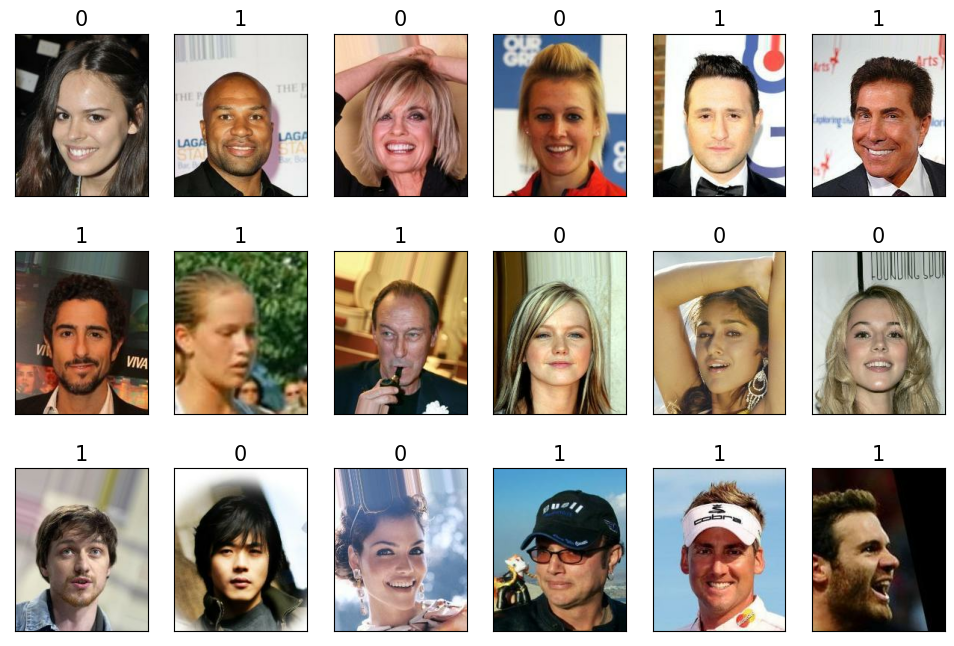

In [58]:
fig = plt.figure(figsize=(12, 8))
for i,(image,label) in enumerate(zip(images, labels)):
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image)
    ax.set_title('{}'.format(label), size=15)
    
# plt.savefig('images/13_3.png', dpi=300)
plt.show()

CelebA 이미지 데이터셋을 사용하기 위해 필요한 작업을 마쳤다.  

그다음 `tensorflow_datasets`에서 데이터셋을 로드하기 위한 두 번째 방법을 알아보자. 데이터셋을 로드하기 위한 앞의 세 단계를 하나로 연결한 래퍼 함수인 `load()`를 사용하는 것이다.  
이 함수를 사용해 MNIST 숫자 데이터셋을 로드해보자.

In [59]:
mnist, mnist_info = tfds.load('mnist', with_info=True,
                              shuffle_files=False)

print(mnist_info)

print(mnist.keys())


tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/hanhyeongu/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""

여기서 볼 수 있듯이 MNIST 데이터셋은 두 부분으로 나뉘어져 있다. 훈련 데이터에 딕셔너리 원소를 튜플로 만드는 변환을 적용하고 열 개의 샘플을 출력해보자.

(10, 28, 28, 1) tf.Tensor([4 1 0 7 8 1 2 7 1 6], shape=(10,), dtype=int64)


2022-11-22 16:04:39.093084: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


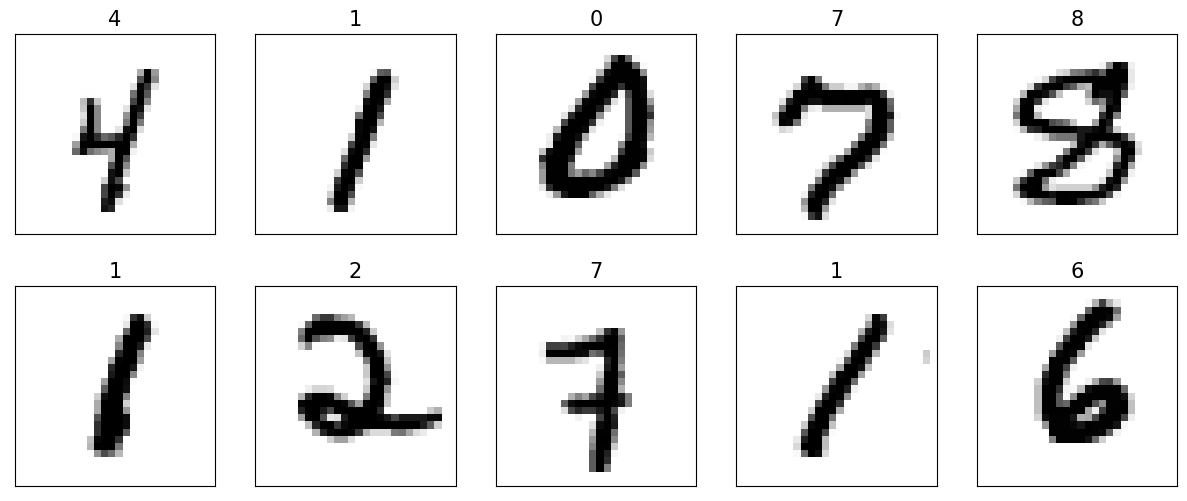

In [60]:
ds_train = mnist['train']

assert isinstance(ds_train, tf.data.Dataset)

ds_train = ds_train.map(lambda item: 
     (item['image'], item['label']))

ds_train = ds_train.batch(10)
batch = next(iter(ds_train))
print(batch[0].shape, batch[1])

fig = plt.figure(figsize=(15, 6))
for i,(image,label) in enumerate(zip(batch[0], batch[1])):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image[:, :, 0], cmap='gray_r')
    ax.set_title('{}'.format(label), size=15)

# plt.savefig('images/13_4.png', dpi=300)
plt.show()